In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation
from keras.layers import LSTM
import pandas as pd
from numba import jit
import os

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

Using TensorFlow backend.


# lstm model

In [3]:
# input: sector name (sign: for calculating accurancy and prediction), number of epoch
# output: sector name (sign), rmse (mean squared error under squared root), prediction for input sector (yhat2)

def lstm_model(sign ,n_epoch=50):
    # convert series to supervised learning
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    
    #################### Divide data into train and test sets to calculate model accurancy ####################
    if sign == 'XLK':
        dataset = read_csv('data/data_XLK.csv', header=0, index_col=0)
        da1 = dataset[['Date','XLK']]
        da2 = dataset[['Date','GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLB','XLY','XLI','XLF','XLU','XLE','XLV','GSPC']]
    if sign == 'XLB':
        dataset = read_csv('data/data_XLB.csv', header=0, index_col=0)
        da1 = dataset[['Date','XLB']]
        da2 = dataset[['Date','GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLK','XLY','XLI','XLF','XLU','XLE','XLV','GSPC']]
    if sign == 'XLY':
        dataset = read_csv('data/data_XLY.csv', header=0, index_col=0)
        da1 = dataset[['Date','XLY']]
        da2 = dataset[['Date','GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLK','XLB','XLI','XLF','XLU','XLE','XLV','GSPC']]
    if sign == 'XLI':
        dataset = read_csv('data/data_XLI.csv', header=0, index_col=0)
        da1 = dataset[['Date','XLI']]
        da2 = dataset[['Date','GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLK','XLY','XLB','XLF','XLU','XLE','XLV','GSPC']]
    if sign == 'XLF':
        dataset = read_csv('data/data_XLF.csv', header=0, index_col=0)
        da1 = dataset[['Date','XLF']]
        da2 = dataset[['Date','GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLK','XLY','XLI','XLB','XLU','XLE','XLV','GSPC']]
    if sign == 'XLU':
        dataset = read_csv('data/data_XLU.csv', header=0, index_col=0)
        da1 = dataset[['Date','XLU']]
        da2 = dataset[['Date','GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLK','XLY','XLI','XLF','XLB','XLE','XLV','GSPC']]
    if sign == 'XLE':
        dataset = read_csv('data/data_XLE.csv', header=0, index_col=0)
        da1 = dataset[['Date','XLE']]
        da2 = dataset[['Date','GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLK','XLY','XLI','XLF','XLU','XLB','XLV','GSPC']]
    if sign == 'XLV':
        dataset = read_csv('data/data_XLV.csv', header=0, index_col=0)
        da1 = dataset[['Date','XLV']]
        da2 = dataset[['Date','GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLK','XLY','XLI','XLF','XLU','XLE','XLB','GSPC']]
    if sign == 'GSPC':
        dataset = read_csv('data/data_GSPC.csv', header=0, index_col=0)
        da1 = dataset[['Date','GSPC']]
        da2 = dataset[['Date','GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLK','XLY','XLI','XLF','XLU','XLE','XLV','XLB']]

    dataset = pd.merge(da1,da2,how='left',on='Date')
    dataset = dataset.drop(columns='Date')
    values = dataset.values

    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    n_lag = 1
    n_features = 15
    # frame as supervised learning
    reframed = series_to_supervised(scaled, n_lag, 1)
    #print(reframed.shape)

    # split into train and test sets, use first 
    values = reframed.values
    n_test_days = 1000
    #use first 1000 days to test, and remaining days to train
    train = values[:-n_test_days,:]
    test = values[-n_test_days:, :]
    # split into input and outputs
    n_obs = n_lag * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    #print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    # design network
    model = Sequential()
    model.add(LSTM(output_dim=50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.add(Activation('tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mae', optimizer='adam')

    # fit network
    history = model.fit(train_X, train_y, epochs=n_epoch, batch_size=72, \
                        validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    # make a prediction
    yhat = model.predict(test_X)
    # actual data
    test_y = test_y.reshape((len(test_y), 1))
    # calculate RMSE
    rmse = sqrt(mean_squared_error(test_y, yhat))
    
    
    ################################ Use all data to fit the model and predict ################################
    #use all data to fit network
    alldata = values[:, :]
    alldata_X, alldata_y = alldata[:, :n_obs], alldata[:, -n_features]
    alldata_X = alldata_X.reshape((alldata_X.shape[0], n_lag, n_features))
    
    # design network
    model = Sequential()
    model.add(LSTM(output_dim=50, input_shape=(alldata_X.shape[1], alldata_X.shape[2])))
    model.add(Dense(1))
    model.add(Activation('tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(alldata_X, alldata_y, epochs=n_epoch, batch_size=72, \
                        verbose=2, shuffle=False)
    # load dataset to predict
    if sign == 'XLK':
        dataset = read_csv('future/X_future_XLK.csv', header=0, index_col=0)
        da = dataset[['GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLB','XLY','XLI','XLF','XLU','XLE','XLV','GSPC']]
    if sign == 'XLB':
        dataset = read_csv('future/X_future_XLB.csv', header=0, index_col=0)
        da = dataset[['GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLK','XLY','XLI','XLF','XLU','XLE','XLV','GSPC']]
    if sign == 'XLY':
        dataset = read_csv('future/X_future_XLY.csv', header=0, index_col=0)
        da = dataset[['GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLK','XLB','XLI','XLF','XLU','XLE','XLV','GSPC']]    
    if sign == 'XLI':
        dataset = read_csv('future/X_future_XLI.csv', header=0, index_col=0)
        da = dataset[['GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLK','XLY','XLB','XLF','XLU','XLE','XLV','GSPC']]
    if sign == 'XLF':
        dataset = read_csv('future/X_future_XLF.csv', header=0, index_col=0)
        da = dataset[['GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLK','XLY','XLI','XLB','XLU','XLE','XLV','GSPC']]
    if sign == 'XLU':
        dataset = read_csv('future/X_future_XLU.csv', header=0, index_col=0)
        da = dataset[['GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLK','XLY','XLI','XLF','XLB','XLE','XLV','GSPC']]
    if sign == 'XLE':
        dataset = read_csv('future/X_future_XLE.csv', header=0, index_col=0)
        da = dataset[['GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLK','XLY','XLI','XLF','XLU','XLB','XLV','GSPC']]
    if sign == 'XLV':
        dataset = read_csv('future/X_future_XLV.csv', header=0, index_col=0)
        da = dataset[['GDP','FEDFUNDS','LIBOR','MORTGAGE30US','REAL_USER_COST',\
                       'UNEMPLOYMENT_RT','XLK','XLY','XLI','XLF','XLU','XLE','XLB','GSPC']]
    dataset = da
    values = dataset.values
    # use future data to predict
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, n_lag, 1)
    #print(reframed.shape)

    # split into train and test sets, use first 
    values = reframed.values
    alldata = values[:, :]
    alldata_X= alldata[:, :n_obs]
    alldata_X = alldata_X.reshape((alldata_X.shape[0], n_lag, n_features))
    # make a prediction
    yhat2 = model.predict(alldata_X)
    # to get same dimension return result as DNN model, we add one result in the end
    yhat2=yhat2.T[0].tolist()
    yhat2.append(yhat2[-1])
    
    return sign,rmse,yhat2

Train on 2577 samples, validate on 1000 samples
Epoch 1/50
 - 2s - loss: 0.3178 - val_loss: 0.1570
Epoch 2/50
 - 0s - loss: 0.2615 - val_loss: 0.1917
Epoch 3/50
 - 0s - loss: 0.2181 - val_loss: 0.2156
Epoch 4/50
 - 0s - loss: 0.1933 - val_loss: 0.2330
Epoch 5/50
 - 0s - loss: 0.1769 - val_loss: 0.2480
Epoch 6/50
 - 0s - loss: 0.1640 - val_loss: 0.2615
Epoch 7/50
 - 0s - loss: 0.1530 - val_loss: 0.2738
Epoch 8/50
 - 0s - loss: 0.1432 - val_loss: 0.2854
Epoch 9/50
 - 0s - loss: 0.1345 - val_loss: 0.2961
Epoch 10/50
 - 0s - loss: 0.1270 - val_loss: 0.3058
Epoch 11/50
 - 0s - loss: 0.1202 - val_loss: 0.3149
Epoch 12/50
 - 0s - loss: 0.1143 - val_loss: 0.3232
Epoch 13/50
 - 0s - loss: 0.1090 - val_loss: 0.3309
Epoch 14/50
 - 0s - loss: 0.1045 - val_loss: 0.3379
Epoch 15/50
 - 0s - loss: 0.1006 - val_loss: 0.3443
Epoch 16/50
 - 0s - loss: 0.0972 - val_loss: 0.3503
Epoch 17/50
 - 0s - loss: 0.0941 - val_loss: 0.3558
Epoch 18/50
 - 0s - loss: 0.0912 - val_loss: 0.3610
Epoch 19/50
 - 0s - loss:

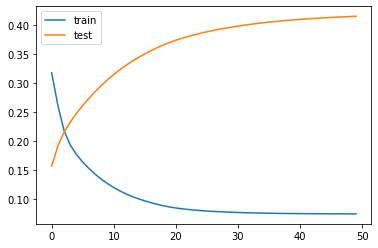

Epoch 1/50
 - 2s - loss: 0.2763
Epoch 2/50
 - 0s - loss: 0.2626
Epoch 3/50
 - 0s - loss: 0.2478
Epoch 4/50
 - 0s - loss: 0.2367
Epoch 5/50
 - 0s - loss: 0.2289
Epoch 6/50
 - 0s - loss: 0.2230
Epoch 7/50
 - 0s - loss: 0.2180
Epoch 8/50
 - 0s - loss: 0.2137
Epoch 9/50
 - 0s - loss: 0.2100
Epoch 10/50
 - 0s - loss: 0.2067
Epoch 11/50
 - 0s - loss: 0.2038
Epoch 12/50
 - 0s - loss: 0.2010
Epoch 13/50
 - 0s - loss: 0.1984
Epoch 14/50
 - 0s - loss: 0.1960
Epoch 15/50
 - 0s - loss: 0.1938
Epoch 16/50
 - 0s - loss: 0.1917
Epoch 17/50
 - 0s - loss: 0.1897
Epoch 18/50
 - 0s - loss: 0.1878
Epoch 19/50
 - 0s - loss: 0.1860
Epoch 20/50
 - 0s - loss: 0.1843
Epoch 21/50
 - 0s - loss: 0.1827
Epoch 22/50
 - 0s - loss: 0.1812
Epoch 23/50
 - 0s - loss: 0.1797
Epoch 24/50
 - 0s - loss: 0.1785
Epoch 25/50
 - 0s - loss: 0.1774
Epoch 26/50
 - 0s - loss: 0.1763
Epoch 27/50
 - 0s - loss: 0.1753
Epoch 28/50
 - 0s - loss: 0.1744
Epoch 29/50
 - 0s - loss: 0.1736
Epoch 30/50
 - 0s - loss: 0.1728
Epoch 31/50
 - 0s -

In [4]:
output = lstm_model('XLK')

In [5]:
#output[2]

In [6]:
def run_all_models():
    sectors = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLU', 'XLV', 'XLY']
    models_l = list()
    for sector in sectors:
        print('Starting model for: ', sector)
        temp_output = lstm_model(sector)
        output_2=temp_output[2]
        models_l.append(output_2)
    return models_l


def sector_rank(models):
    #models is a list of lists
    #for each sector in the list, it is the daily close prices
    #position 0 = the close of last day real data
    #position 250? will be 1 years out forcast
    # position -1 will be 2 years out forcast
    sectors = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLU', 'XLV', 'XLY']
    sec_returns_l = list()
    for i in range(len(models)):
        #year 1 return calculation
        y1_temp = models[i]
        sec_returns_l.append(y1_temp)
        
    return sec_returns_l

Starting model for:  XLB
Train on 2577 samples, validate on 1000 samples
Epoch 1/50
 - 2s - loss: 0.1982 - val_loss: 0.3241
Epoch 2/50
 - 0s - loss: 0.1834 - val_loss: 0.3499
Epoch 3/50
 - 0s - loss: 0.1719 - val_loss: 0.3674
Epoch 4/50
 - 0s - loss: 0.1634 - val_loss: 0.3790
Epoch 5/50
 - 0s - loss: 0.1580 - val_loss: 0.3875
Epoch 6/50
 - 0s - loss: 0.1545 - val_loss: 0.3945
Epoch 7/50
 - 0s - loss: 0.1520 - val_loss: 0.4004
Epoch 8/50
 - 0s - loss: 0.1499 - val_loss: 0.4056
Epoch 9/50
 - 0s - loss: 0.1481 - val_loss: 0.4099
Epoch 10/50
 - 0s - loss: 0.1462 - val_loss: 0.4128
Epoch 11/50
 - 0s - loss: 0.1439 - val_loss: 0.4116
Epoch 12/50
 - 0s - loss: 0.1395 - val_loss: 0.3907
Epoch 13/50
 - 0s - loss: 0.1335 - val_loss: 0.3430
Epoch 14/50
 - 0s - loss: 0.1297 - val_loss: 0.3199
Epoch 15/50
 - 0s - loss: 0.1245 - val_loss: 0.3082
Epoch 16/50
 - 0s - loss: 0.1210 - val_loss: 0.2935
Epoch 17/50
 - 0s - loss: 0.1176 - val_loss: 0.2844
Epoch 18/50
 - 0s - loss: 0.1152 - val_loss: 0.2747


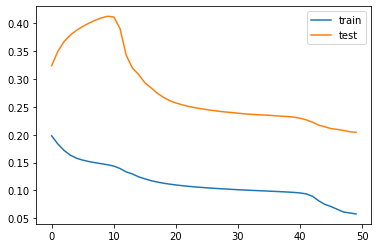

Epoch 1/50
 - 2s - loss: 0.2404
Epoch 2/50
 - 0s - loss: 0.2131
Epoch 3/50
 - 0s - loss: 0.1895
Epoch 4/50
 - 0s - loss: 0.1615
Epoch 5/50
 - 0s - loss: 0.1342
Epoch 6/50
 - 0s - loss: 0.1147
Epoch 7/50
 - 0s - loss: 0.1064
Epoch 8/50
 - 0s - loss: 0.1025
Epoch 9/50
 - 0s - loss: 0.1002
Epoch 10/50
 - 0s - loss: 0.0985
Epoch 11/50
 - 0s - loss: 0.0970
Epoch 12/50
 - 0s - loss: 0.0956
Epoch 13/50
 - 0s - loss: 0.0941
Epoch 14/50
 - 0s - loss: 0.0926
Epoch 15/50
 - 0s - loss: 0.0907
Epoch 16/50
 - 0s - loss: 0.0883
Epoch 17/50
 - 0s - loss: 0.0854
Epoch 18/50
 - 0s - loss: 0.0825
Epoch 19/50
 - 0s - loss: 0.0797
Epoch 20/50
 - 0s - loss: 0.0762
Epoch 21/50
 - 0s - loss: 0.0735
Epoch 22/50
 - 0s - loss: 0.0714
Epoch 23/50
 - 0s - loss: 0.0693
Epoch 24/50
 - 0s - loss: 0.0677
Epoch 25/50
 - 0s - loss: 0.0670
Epoch 26/50
 - 0s - loss: 0.0664
Epoch 27/50
 - 0s - loss: 0.0652
Epoch 28/50
 - 0s - loss: 0.0680
Epoch 29/50
 - 0s - loss: 0.0780
Epoch 30/50
 - 0s - loss: 0.0660
Epoch 31/50
 - 0s -

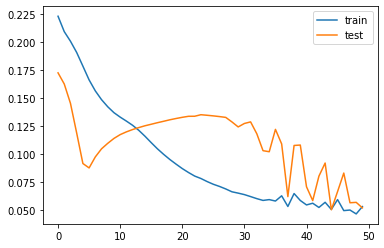

Epoch 1/50
 - 2s - loss: 0.2143
Epoch 2/50
 - 0s - loss: 0.1808
Epoch 3/50
 - 0s - loss: 0.1625
Epoch 4/50
 - 0s - loss: 0.1469
Epoch 5/50
 - 0s - loss: 0.1356
Epoch 6/50
 - 0s - loss: 0.1253
Epoch 7/50
 - 0s - loss: 0.1170
Epoch 8/50
 - 0s - loss: 0.1104
Epoch 9/50
 - 0s - loss: 0.1049
Epoch 10/50
 - 0s - loss: 0.1006
Epoch 11/50
 - 0s - loss: 0.0974
Epoch 12/50
 - 0s - loss: 0.0934
Epoch 13/50
 - 0s - loss: 0.0880
Epoch 14/50
 - 0s - loss: 0.0823
Epoch 15/50
 - 0s - loss: 0.0771
Epoch 16/50
 - 0s - loss: 0.0720
Epoch 17/50
 - 0s - loss: 0.0677
Epoch 18/50
 - 0s - loss: 0.0662
Epoch 19/50
 - 0s - loss: 0.0669
Epoch 20/50
 - 0s - loss: 0.0657
Epoch 21/50
 - 0s - loss: 0.0582
Epoch 22/50
 - 0s - loss: 0.0644
Epoch 23/50
 - 0s - loss: 0.0584
Epoch 24/50
 - 0s - loss: 0.0521
Epoch 25/50
 - 0s - loss: 0.0505
Epoch 26/50
 - 0s - loss: 0.0543
Epoch 27/50
 - 0s - loss: 0.0548
Epoch 28/50
 - 0s - loss: 0.0562
Epoch 29/50
 - 0s - loss: 0.0552
Epoch 30/50
 - 0s - loss: 0.0487
Epoch 31/50
 - 0s -

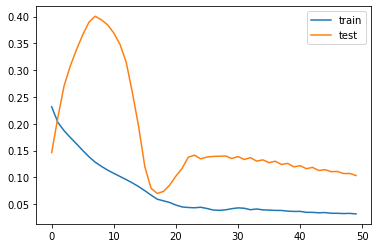

Epoch 1/50
 - 2s - loss: 0.2090
Epoch 2/50
 - 0s - loss: 0.2074
Epoch 3/50
 - 0s - loss: 0.2058
Epoch 4/50
 - 0s - loss: 0.2037
Epoch 5/50
 - 0s - loss: 0.2003
Epoch 6/50
 - 0s - loss: 0.1939
Epoch 7/50
 - 0s - loss: 0.1848
Epoch 8/50
 - 0s - loss: 0.1754
Epoch 9/50
 - 0s - loss: 0.1676
Epoch 10/50
 - 0s - loss: 0.1610
Epoch 11/50
 - 0s - loss: 0.1552
Epoch 12/50
 - 0s - loss: 0.1499
Epoch 13/50
 - 0s - loss: 0.1450
Epoch 14/50
 - 0s - loss: 0.1422
Epoch 15/50
 - 0s - loss: 0.1367
Epoch 16/50
 - 0s - loss: 0.1333
Epoch 17/50
 - 0s - loss: 0.1290
Epoch 18/50
 - 0s - loss: 0.1293
Epoch 19/50
 - 0s - loss: 0.1264
Epoch 20/50
 - 0s - loss: 0.1226
Epoch 21/50
 - 0s - loss: 0.1194
Epoch 22/50
 - 0s - loss: 0.1158
Epoch 23/50
 - 0s - loss: 0.1134
Epoch 24/50
 - 0s - loss: 0.1102
Epoch 25/50
 - 0s - loss: 0.1108
Epoch 26/50
 - 0s - loss: 0.1084
Epoch 27/50
 - 0s - loss: 0.1023
Epoch 28/50
 - 0s - loss: 0.0948
Epoch 29/50
 - 0s - loss: 0.0983
Epoch 30/50
 - 0s - loss: 0.0922
Epoch 31/50
 - 0s -

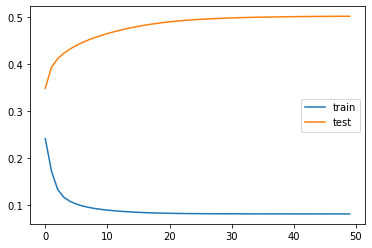

Epoch 1/50
 - 2s - loss: 0.2684
Epoch 2/50
 - 0s - loss: 0.2475
Epoch 3/50
 - 0s - loss: 0.2348
Epoch 4/50
 - 0s - loss: 0.2252
Epoch 5/50
 - 0s - loss: 0.2127
Epoch 6/50
 - 0s - loss: 0.1805
Epoch 7/50
 - 0s - loss: 0.1588
Epoch 8/50
 - 0s - loss: 0.1401
Epoch 9/50
 - 0s - loss: 0.1275
Epoch 10/50
 - 0s - loss: 0.1177
Epoch 11/50
 - 0s - loss: 0.1092
Epoch 12/50
 - 0s - loss: 0.1022
Epoch 13/50
 - 0s - loss: 0.0968
Epoch 14/50
 - 0s - loss: 0.0927
Epoch 15/50
 - 0s - loss: 0.0895
Epoch 16/50
 - 0s - loss: 0.0869
Epoch 17/50
 - 0s - loss: 0.0847
Epoch 18/50
 - 0s - loss: 0.0827
Epoch 19/50
 - 0s - loss: 0.0810
Epoch 20/50
 - 0s - loss: 0.0795
Epoch 21/50
 - 0s - loss: 0.0781
Epoch 22/50
 - 0s - loss: 0.0769
Epoch 23/50
 - 0s - loss: 0.0759
Epoch 24/50
 - 0s - loss: 0.0750
Epoch 25/50
 - 0s - loss: 0.0744
Epoch 26/50
 - 0s - loss: 0.0736
Epoch 27/50
 - 0s - loss: 0.0731
Epoch 28/50
 - 0s - loss: 0.0724
Epoch 29/50
 - 0s - loss: 0.0721
Epoch 30/50
 - 0s - loss: 0.0715
Epoch 31/50
 - 0s -

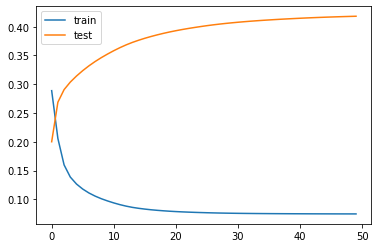

Epoch 1/50
 - 2s - loss: 0.2760
Epoch 2/50
 - 0s - loss: 0.2494
Epoch 3/50
 - 0s - loss: 0.2309
Epoch 4/50
 - 0s - loss: 0.2194
Epoch 5/50
 - 0s - loss: 0.2128
Epoch 6/50
 - 0s - loss: 0.2081
Epoch 7/50
 - 0s - loss: 0.2045
Epoch 8/50
 - 0s - loss: 0.2013
Epoch 9/50
 - 0s - loss: 0.1985
Epoch 10/50
 - 0s - loss: 0.1959
Epoch 11/50
 - 0s - loss: 0.1935
Epoch 12/50
 - 0s - loss: 0.1913
Epoch 13/50
 - 0s - loss: 0.1892
Epoch 14/50
 - 0s - loss: 0.1873
Epoch 15/50
 - 0s - loss: 0.1855
Epoch 16/50
 - 0s - loss: 0.1838
Epoch 17/50
 - 0s - loss: 0.1822
Epoch 18/50
 - 0s - loss: 0.1806
Epoch 19/50
 - 0s - loss: 0.1792
Epoch 20/50
 - 0s - loss: 0.1780
Epoch 21/50
 - 0s - loss: 0.1769
Epoch 22/50
 - 0s - loss: 0.1758
Epoch 23/50
 - 0s - loss: 0.1749
Epoch 24/50
 - 0s - loss: 0.1740
Epoch 25/50
 - 0s - loss: 0.1731
Epoch 26/50
 - 0s - loss: 0.1724
Epoch 27/50
 - 0s - loss: 0.1718
Epoch 28/50
 - 0s - loss: 0.1712
Epoch 29/50
 - 0s - loss: 0.1706
Epoch 30/50
 - 0s - loss: 0.1700
Epoch 31/50
 - 0s -

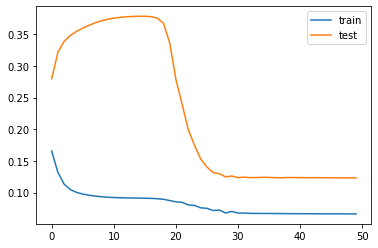

Epoch 1/50
 - 2s - loss: 0.2004
Epoch 2/50
 - 0s - loss: 0.1605
Epoch 3/50
 - 0s - loss: 0.1262
Epoch 4/50
 - 0s - loss: 0.0990
Epoch 5/50
 - 0s - loss: 0.0735
Epoch 6/50
 - 0s - loss: 0.0651
Epoch 7/50
 - 0s - loss: 0.0638
Epoch 8/50
 - 0s - loss: 0.0623
Epoch 9/50
 - 0s - loss: 0.0611
Epoch 10/50
 - 0s - loss: 0.0599
Epoch 11/50
 - 0s - loss: 0.0585
Epoch 12/50
 - 0s - loss: 0.0571
Epoch 13/50
 - 0s - loss: 0.0557
Epoch 14/50
 - 0s - loss: 0.0540
Epoch 15/50
 - 0s - loss: 0.0523
Epoch 16/50
 - 0s - loss: 0.0508
Epoch 17/50
 - 0s - loss: 0.0493
Epoch 18/50
 - 0s - loss: 0.0479
Epoch 19/50
 - 0s - loss: 0.0464
Epoch 20/50
 - 0s - loss: 0.0450
Epoch 21/50
 - 0s - loss: 0.0439
Epoch 22/50
 - 0s - loss: 0.0428
Epoch 23/50
 - 0s - loss: 0.0419
Epoch 24/50
 - 0s - loss: 0.0411
Epoch 25/50
 - 0s - loss: 0.0403
Epoch 26/50
 - 0s - loss: 0.0396
Epoch 27/50
 - 0s - loss: 0.0394
Epoch 28/50
 - 0s - loss: 0.0388
Epoch 29/50
 - 0s - loss: 0.0383
Epoch 30/50
 - 0s - loss: 0.0377
Epoch 31/50
 - 0s -

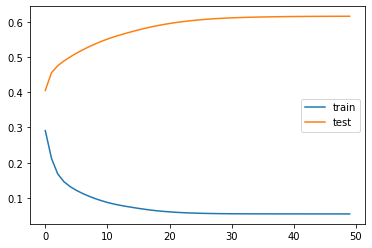

Epoch 1/50
 - 2s - loss: 0.3318
Epoch 2/50
 - 0s - loss: 0.2666
Epoch 3/50
 - 0s - loss: 0.2344
Epoch 4/50
 - 0s - loss: 0.2206
Epoch 5/50
 - 0s - loss: 0.2120
Epoch 6/50
 - 0s - loss: 0.1961
Epoch 7/50
 - 0s - loss: 0.1277
Epoch 8/50
 - 0s - loss: 0.0870
Epoch 9/50
 - 0s - loss: 0.0497
Epoch 10/50
 - 0s - loss: 0.0466
Epoch 11/50
 - 0s - loss: 0.0447
Epoch 12/50
 - 0s - loss: 0.0437
Epoch 13/50
 - 0s - loss: 0.0425
Epoch 14/50
 - 0s - loss: 0.0419
Epoch 15/50
 - 0s - loss: 0.0412
Epoch 16/50
 - 0s - loss: 0.0406
Epoch 17/50
 - 0s - loss: 0.0402
Epoch 18/50
 - 0s - loss: 0.0400
Epoch 19/50
 - 0s - loss: 0.0395
Epoch 20/50
 - 0s - loss: 0.0393
Epoch 21/50
 - 0s - loss: 0.0390
Epoch 22/50
 - 0s - loss: 0.0387
Epoch 23/50
 - 0s - loss: 0.0384
Epoch 24/50
 - 0s - loss: 0.0382
Epoch 25/50
 - 0s - loss: 0.0380
Epoch 26/50
 - 0s - loss: 0.0378
Epoch 27/50
 - 0s - loss: 0.0376
Epoch 28/50
 - 0s - loss: 0.0374
Epoch 29/50
 - 0s - loss: 0.0372
Epoch 30/50
 - 0s - loss: 0.0370
Epoch 31/50
 - 0s -

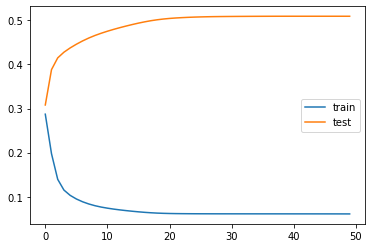

Epoch 1/50
 - 2s - loss: 0.2859
Epoch 2/50
 - 0s - loss: 0.2656
Epoch 3/50
 - 0s - loss: 0.2525
Epoch 4/50
 - 0s - loss: 0.2446
Epoch 5/50
 - 0s - loss: 0.2395
Epoch 6/50
 - 0s - loss: 0.2354
Epoch 7/50
 - 0s - loss: 0.2317
Epoch 8/50
 - 0s - loss: 0.2266
Epoch 9/50
 - 0s - loss: 0.2003
Epoch 10/50
 - 0s - loss: 0.1723
Epoch 11/50
 - 0s - loss: 0.1554
Epoch 12/50
 - 0s - loss: 0.1398
Epoch 13/50
 - 0s - loss: 0.1319
Epoch 14/50
 - 0s - loss: 0.1229
Epoch 15/50
 - 0s - loss: 0.1146
Epoch 16/50
 - 0s - loss: 0.1076
Epoch 17/50
 - 0s - loss: 0.1010
Epoch 18/50
 - 0s - loss: 0.0955
Epoch 19/50
 - 0s - loss: 0.0905
Epoch 20/50
 - 0s - loss: 0.0857
Epoch 21/50
 - 0s - loss: 0.0815
Epoch 22/50
 - 0s - loss: 0.0770
Epoch 23/50
 - 0s - loss: 0.0739
Epoch 24/50
 - 0s - loss: 0.0699
Epoch 25/50
 - 0s - loss: 0.0681
Epoch 26/50
 - 0s - loss: 0.0645
Epoch 27/50
 - 0s - loss: 0.0642
Epoch 28/50
 - 0s - loss: 0.0599
Epoch 29/50
 - 0s - loss: 0.0614
Epoch 30/50
 - 0s - loss: 0.0555
Epoch 31/50
 - 0s -

In [7]:
returns_list = sector_rank(run_all_models())

In [8]:
def end_rank_log(output):
    sectors = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLU', 'XLV', 'XLY']
    sector_names = ['Materials', 'Energy', 'Financials', 'Industrials', 'Technology',
                   'Utilities', 'Health Care', 'Consumer Discretionary']
    output_l = list()
    for item in output:
        val = sum(item)
        output_l.append((val))
            
    #turn each into a dataframe
    returns_df = pd.DataFrame({'sector': sector_names, 'sector_symbol':sectors, 'sum log(% returns)':output_l})
    #sort
    returns_df_sorted = returns_df.sort_values(by='sum log(% returns)', ascending = False).reset_index(drop=True)
    print('Reccomended investments in ', returns_df_sorted.iloc[0,0], 'sector')
    print(returns_df_sorted)
    return returns_df_sorted

# Final Output rankings

In [9]:
lstm_output = end_rank_log(returns_list)

Reccomended investments in  Financials sector
                   sector sector_symbol  sum log(% returns)
0              Financials           XLF           77.460677
1             Health Care           XLV           64.303805
2                  Energy           XLE           62.829617
3             Industrials           XLI           56.132897
4               Materials           XLB           46.264915
5  Consumer Discretionary           XLY           43.106883
6               Utilities           XLU           42.590521
7              Technology           XLK           25.132788


In [10]:
lstm_output

,sector,sector_symbol,sum log(% returns)
0,Financials,XLF,77.460677
1,Health Care,XLV,64.303805
2,Energy,XLE,62.829617
3,Industrials,XLI,56.132897
4,Materials,XLB,46.264915
5,Consumer Discretionary,XLY,43.106883
6,Utilities,XLU,42.590521
7,Technology,XLK,25.132788
